In [1]:
import numpy as np
import terra

from meerkat.contrib.eeg import build_stanford_eeg_dp

from domino.emb.eeg import generate_words_dp, embed_words, embed_eeg
from domino.evaluate import run_sdms, score_sdm_explanations, score_sdms, run_sdm
from domino.sdm import MixtureModelSDM, SpotlightSDM
from domino.slices import collect_settings
from domino.train import score_settings, synthetic_score_settings, train_settings
from domino.utils import split_dp, balance_dp

import meerkat as mk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, roc_auc_score


/home/ksaab/Documents/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(
[nltk_data] Downloading package punkt to /home/ksaab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
setting_dp = collect_settings.out(load=True)
setting_dp

,alpha (NumpyArrayColumn),build_setting_kwargs (ListColumn),dataset (PandasSeriesColumn),slice_category (PandasSeriesColumn),slice_names (ListColumn),target_name (PandasSeriesColumn),index (PandasSeriesColumn),setting_id (PandasSeriesColumn)
0,0.100000,"{'target_frac': 0.5, 'error_rate': 0.1, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,0,3cd58895-8964-4117-b9b5-35a02abc855d
1,0.144444,"{'target_frac': 0.5, 'error_rate': 0.14444444444444446, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,1,335598cf-1bf4-439b-9869-a9be2c620a08
2,0.188889,"{'target_frac': 0.5, 'error_rate': 0.18888888888888888, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,2,c5fd24ef-dc70-468b-8bce-c33aa28fdbeb
3,0.233333,"{'target_frac': 0.5, 'error_rate': 0.23333333333333334, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,3,ef04535a-0b00-4fed-a960-5f1646c5e0bd
4,0.277778,"{'target_frac': 0.5, 'error_rate': 0.2777777777777778, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,4,0d5a4bdf-27fc-4c59-8b71-e5d3f8479f43
5,0.322222,"{'target_frac': 0.5, 'error_rate': 0.32222222222222224, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,5,4417b01c-637f-4212-bf3b-2a4bdf59221c
6,0.366667,"{'target_frac': 0.5, 'error_rate': 0.3666666666666667, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,6,3240bb85-caf3-44e5-88ee-306685e353c6
7,0.411111,"{'target_frac': 0.5, 'error_rate': 0.4111111111111111, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,7,97ab43ed-0874-4f24-8c9c-93ba6c918ff9
8,0.455556,"{'target_frac': 0.5, 'error_rate': 0.4555555555555556, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,8,2fce5033-66df-4b68-998a-e59cdac0aacf
9,0.500000,"{'target_frac': 0.5, 'error_rate': 0.5, 'n': 8000, 'attribute': 'age', 'attribute_thresh': 1}",eeg,noisy_label,['age<1'],sz,9,0dfe192e-659b-46c4-914d-611ebfb103ba


In [9]:
run_sdms_dp = run_sdms.out(7051,load=True)
run_sdms_dp.head()

,score_model_run_id (PandasSeriesColumn),train_model_run_id (PandasSeriesColumn),setting_id (PandasSeriesColumn),dataset (PandasSeriesColumn),index (PandasSeriesColumn),target_name (PandasSeriesColumn),build_setting_kwargs (ListColumn),slice_category (PandasSeriesColumn),slice_names (ListColumn),alpha (NumpyArrayColumn),train_settings_run_id (PandasSeriesColumn),score_settings_run_id (PandasSeriesColumn),synthetic_preds (PandasSeriesColumn),run_sdm_run_id (PandasSeriesColumn),emb_group (PandasSeriesColumn),time_this_iter_s (PandasSeriesColumn),done (PandasSeriesColumn),timesteps_total (PandasSeriesColumn),episodes_total (PandasSeriesColumn),training_iteration (PandasSeriesColumn),experiment_id (PandasSeriesColumn),date (PandasSeriesColumn),timestamp (PandasSeriesColumn),time_total_s (PandasSeriesColumn),pid (PandasSeriesColumn),hostname (PandasSeriesColumn),node_ip (PandasSeriesColumn),time_since_restore (PandasSeriesColumn),timesteps_since_restore (PandasSeriesColumn),iterations_since_restore (PandasSeriesColumn),trial_id (PandasSeriesColumn),sdm_config/weight_y_log_likelihood (PandasSeriesColumn),sdm_config/n_clusters (PandasSeriesColumn),sdm_config/n_slices (PandasSeriesColumn),sdm_config/emb (PandasSeriesColumn),sdm_config/xmodal_emb (PandasSeriesColumn),config/sdm (PandasSeriesColumn),config/slice (PandasSeriesColumn),logdir (PandasSeriesColumn),sdm_config/learning_rate (PandasSeriesColumn),sdm_class (PandasSeriesColumn)
0,4933,4500,b8573da7-8d08-40d2-ac75-3642c41da54b,eeg,0,sz,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}",correlation,"['sz=0_age>1', 'sz=1_age<1']",0.0,4497,4931,False,7082,eeg,4.616104,False,NaN,NaN,1,76b426821f804b049924699ed3e1bd63,2021-10-04_17-27-04,1633393624,4.616104,21822,gemini1,171.65.28.88,4.616104,0,1,e69b0_00000,10.0,10.0,10,emb,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['eeg', 'emb'], 'learning_rate': None, 'n_clusters': 10.0, 'n_slices': 10, 'weight_y_log_likelihood': 10.0, 'xmodal_emb': 'emb'}}","{'alpha': 0.0, 'build_setting_kwargs': {'attribute': None, 'attribute_thresh': None, 'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1.0, 'error_rate': None, 'n': 8000, 'slice_frac': None, 'target_frac': None}, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 4933, 'score_settings_run_id': 4931, 'setting_id': 'b8573da7-8d08-40d2-ac75-3642c41da54b', 'slice_category': 'correlation', 'slice_names': ['sz=0_age>1', 'sz=1_age<1'], 'synthetic_preds': 'False', 'target_name': 'sz', 'train_model_run_id': 4500, 'train_settings_run_id': 4497}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/7051/_evaluate_2021-10-04_17-26-36/_evaluate_e69b0_00000_0_sdm={'sdm_class': , 'sdm_config': {'weight_y_log_likelihood': 10, _2021-10-04_17-26-37",NaN,domino.sdm.gmm.MixtureModelSDM
1,4933,4500,b8573da7-8d08-40d2-ac75-3642c41da54b,eeg,1,sz,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}",correlation,"['sz=0_age>1', 'sz=1_age<1']",0.0,4497,4931,False,7065,multimodal,3.389447,False,NaN,NaN,1,bb3702459f0942f8843a4280261ef256,2021-10-04_17-27-02,1633393622,3.389447,21797,gemini1,171.65.28.88,3.389447,0,1,e69b0_00001,10.0,10.0,10,emb,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['multimodal', 'emb'], 'learning_rate': None, 'n_clusters': 10.0, 'n_slices': 10, 'weight_y_log_likelihood': 10.0, 'xmodal_emb': 'emb'}}","{'alpha': 0.0, 'build_setting_kwargs': {'attribute': None, 'attribute_thresh': None, 'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1.0, 'error_rate': None, 'n': 8000, 'slice_frac': None, 'target_frac': None}, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 4933, 'score_settings_run_id': 4931, 'setting_id': 'b8573da7-8d08-40d2-ac75-3642c41da54b', 'slice_category': 'correlation', 'slice_names': ['sz=0_age>1', 'sz=1_age<1'], 'synthetic_preds': 'False', 'target_name': 'sz', 'train_model_run_id': 4500, 'train_settings_run_id': 4497}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/7051/_evaluate_2021-10-04_17-26-36/_evalua

In [10]:
score_dp = mk.DataPanel.from_pandas(score_sdms.out(7262,load=True))
score_dp

,pred_slice_idx (PandasSeriesColumn),slice_idx (PandasSeriesColumn),auroc (PandasSeriesColumn),precision_at_10 (PandasSeriesColumn),precision_at_25 (PandasSeriesColumn),precision_at_100 (PandasSeriesColumn),recall_at_50 (PandasSeriesColumn),recall_at_100 (PandasSeriesColumn),recall_at_200 (PandasSeriesColumn),recall (PandasSeriesColumn),precision (PandasSeriesColumn),target_name (PandasSeriesColumn),run_sdm_run_id (PandasSeriesColumn),score_model_run_id (PandasSeriesColumn),slice_name (PandasSeriesColumn),index (PandasSeriesColumn)
0,0.0,0.0,0.128553,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,sz,7082.0,4933.0,sz=0_age>1,0
1,1.0,0.0,0.261853,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,sz,7082.0,4933.0,sz=0_age>1,1
2,2.0,0.0,0.152996,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,sz,7082.0,4933.0,sz=0_age>1,2
3,3.0,0.0,0.860434,0.6,0.44,0.42,0.097222,0.194444,0.416667,0.212963,0.418182,sz,7082.0,4933.0,sz=0_age>1,3
4,4.0,0.0,0.831504,0.5,0.56,0.51,0.175926,0.236111,0.532407,0.324074,0.526316,sz,7082.0,4933.0,sz=0_age>1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,5.0,0.0,0.500000,0.0,0.24,0.18,0.000000,0.000000,0.000000,0.000000,0.000000,sz,7229.0,4958.0,age<1,2995
2996,6.0,0.0,0.500000,0.0,0.24,0.18,0.000000,0.000000,0.000000,0.000000,0.000000,sz,7229.0,4958.0,age<1,2996
2997,7.0,0.0,0.500000,0.0,0.24,0.18,0.000000,0.000000,0.000000,0.000000,0.000000,sz,7229.0,4958.0,age<1,2997
2998,8.0,0.0,0.500000,0.0,0.24,0.18,0.000000,0.000000,0.000000,0.000000,0.000000,sz,7229.0,4958.0,age<1,2998


In [11]:
results_dp = mk.merge(
    score_dp,
    run_sdms_dp["sdm_class", "config/sdm", "alpha", "run_sdm_run_id", "build_setting_kwargs", "slice_category"], # include any other columns here you'd like to analyze
    on="run_sdm_run_id"
)
emb_col = results_dp["config/sdm"].map(lambda x: x["sdm_config"]["emb"][0])
results_dp["emb_type"] = emb_col

corr_thresh_col = results_dp["build_setting_kwargs"].map(lambda x: x["correlate_threshold"] if "correlate_threshold" in x else x["attribute_thresh"])
results_dp["corr_thresh"] = corr_thresh_col


results_df = results_dp.to_pandas()
results_df

,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,...,score_model_run_id,slice_name,index,sdm_class,config/sdm,alpha,build_setting_kwargs,slice_category,emb_type,corr_thresh
0,7082,0,0,0.128553,0.0,0.00,0.00,0.000000,0.000000,0.000000,...,4933,sz=0_age>1,0,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.000000,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
1,7082,1,0,0.261853,0.0,0.00,0.00,0.000000,0.000000,0.000000,...,4933,sz=0_age>1,1,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.000000,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
2,7082,2,0,0.152996,0.0,0.00,0.00,0.000000,0.000000,0.000000,...,4933,sz=0_age>1,2,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.000000,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
3,7082,3,0,0.860434,0.6,0.44,0.42,0.097222,0.194444,0.416667,...,4933,sz=0_age>1,3,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.000000,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
4,7082,4,0,0.831504,0.5,0.56,0.51,0.175926,0.236111,0.532407,...,4933,sz=0_age>1,4,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.000000,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,7229,5,0,0.500000,0.0,0.24,0.18,0.000000,0.000000,0.000000,...,4958,age<1,2995,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.322222,"{'target_frac': 0.5, 'error_rate': 0.322222222...",noisy_label,multimodal,1
2996,7229,6,0,0.500000,0.0,0.24,0.18,0.000000,0.000000,0.000000,...,4958,age<1,2996,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.322222,"{'target_frac': 0.5, 'error_rate': 0.322222222...",noisy_label,multimodal,1
2997,7229,7,0,0.500000,0.0,0.24,0.18,0.000000,0.000000,0.000000,...,4958,age<1,2997,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.322222,"{'target_frac': 0.5, 'error_rate': 0.322222222...",noisy_label,multimodal,1
2998,7229,8,0,0.500000,0.0,0.24,0.18,0.000000,0.000000,0.000000,...,4958,age<1,2998,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.322222,"{'target_frac': 0.5, 'error_rate': 0.322222222...",noisy_label,multimodal,1


<ipython-input-12-1ae986468436>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["success"] = grouped_df["precision_at_10"] > 0.6
[2021-10-04 22:48:51,357][WARNING][matplotlib.legend:1225] :: No handles with labels found to put in legend.


300


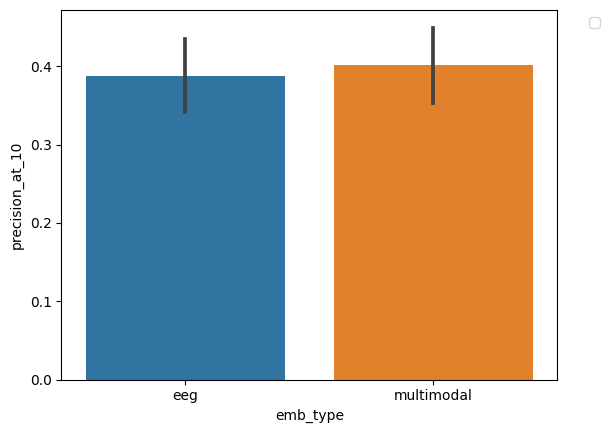

In [12]:
metric = "precision_at_10"
grouped_df = results_df.iloc[results_df.reset_index().groupby(["sdm_class", "slice_name", "slice_idx","emb_type", "alpha", "corr_thresh", "slice_category"])[metric].idxmax().astype(int)]

grouped_df["success"] = grouped_df["precision_at_10"] > 0.6

print(len(grouped_df))
#ax = sns.lineplot(data=grouped_df,x="alpha",y=metric, hue="emb_type",style="slice_name")
#ax = sns.violinplot(data=grouped_df,x=metric,y="emb_type")
ax = sns.barplot(data=grouped_df,y=metric,x="emb_type")
#ax = sns.displot(data=grouped_df,x=metric,hue="sdm_class")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [13]:
# metric = "auroc"
# grouped_df = results_df.iloc[results_df.reset_index().groupby(["sdm_class", "slice_name", "slice_idx","emb_type","alpha","corr_thresh"])[metric].idxmax().astype(int)]


# #ax = sns.lineplot(data=grouped_df,x="alpha",y=metric, hue="emb_type",style="slice_name")
# ax = sns.barplot(data=grouped_df,x=metric,y="slice_category",hue="sdm_class")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [14]:
specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]
specific_run

<ipython-input-14-2102573fa2db>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]


,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,...,slice_name,index,sdm_class,config/sdm,alpha,build_setting_kwargs,slice_category,emb_type,corr_thresh,success
181,7070,1,0,0.898309,0.3,0.32,0.38,0.060185,0.175926,0.49537,...,sz=0_age>1,181,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,multimodal,1,False


In [15]:
sdm_dp, _ = run_sdm.out(specific_run["run_sdm_run_id"].values[0],load=True)
sdm_dp.head()

,id (PandasSeriesColumn),file_id (PandasSeriesColumn),age (NumpyArrayColumn),fm_split (PandasSeriesColumn),sz_start_index (NumpyArrayColumn),index (PandasSeriesColumn),filepath (PandasSeriesColumn),input (LambdaColumn),target (NumpyArrayColumn),duration (NumpyArrayColumn),binarized_age (NumpyArrayColumn),slices (NumpyArrayColumn),split (PandasSeriesColumn),output (ClassificationOutputColumn),probs (ClassificationOutputColumn),pred_slices (NumpyArrayColumn),emb (NumpyArrayColumn)
0,CA893331_1-1+_1.0,CA893331_1-1+,0.061999,train,1.0,2293,/media/4tb_hdd/eeg_data/lpch/lpch/CA893331_1-1+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",True,1606.8,0,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
1,CA893331_1-1+_3.0,CA893331_1-1+,0.061999,train,3.0,2293,/media/4tb_hdd/eeg_data/lpch/lpch/CA893331_1-1+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",True,1606.8,0,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
2,DA05518A_1-1+_-1.0,DA05518A_1-1+,1.228876,train,-1.0,37650,/media/4tb_hdd/eeg_data/lpch/lpch/DA05518A_1-1+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",False,1435.0,1,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
3,DA0552WF_1-8+_-1.0,DA0552WF_1-8+,0.009749,train,-1.0,19271,/media/4tb_hdd/eeg_data/lpch/lpch/DA0552WF_1-8+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",False,500.0,0,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"
4,CA3464C1_1-7+_-1.0,CA3464C1_1-7+,62.107717,train,-1.0,27568,/media/4tb_hdd/eeg_data/stanford/stanford_mini/CA3464C1_1-7+.eeghdf,"LambdaCell(fn=functools.partial(, clip_len=12))",False,474.0,1,"np.ndarray(shape=(2,))",test,torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(10,))","np.ndarray(shape=(128,))"


In [16]:
from domino.slices.abstract import build_setting

specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]
sdm_dp, _ = run_sdm.out(specific_run["run_sdm_run_id"].values[0],load=True)

preds = np.array(sdm_dp.lz["probs"].argmax(1))
targets = np.array(sdm_dp.lz["target"])
in_slice = sdm_dp.lz["slices"][:,0]

print(targets.mean())
tn, fp, fn, tp = confusion_matrix(targets,preds,normalize="true").ravel()
print(f"FP: {fp}, FN: {fn}")

pred_slices = sdm_dp.lz["pred_slices"]
#for ndx in range(10):
ndx=1
pp = pred_slices[:,ndx]
pp = (targets==0)*np.array(sdm_dp.lz["probs"][:,1]>0.5)
#print(roc_auc_score(in_slice,pp))
print(precision_score(in_slice,pp))

#print((preds != targets).mean())
#print((preds[in_slice]!= targets[in_slice]).mean())
fns = np.array((targets==0)*(preds==1))
print(in_slice[fns].mean())

#synth_dp.head()

0.6557788944723618
FP: 0.1678832116788321, FN: 0.6743295019157088
0.2753623188405797
0.2753623188405797


<ipython-input-16-6ef34ff161e5>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==0][grouped_df["alpha"]==0][grouped_df["sdm_class"]=="domino.sdm.confusion.ConfusionSDM"]


In [17]:
pred_slices.argmax(1).min()

0

In [18]:
# grouped_df["success"] = np.logical_and(grouped_df["auroc"] > 0.7, grouped_df["precision_at_10"] > 0.4)

# #ax = sns.pointplot(data=grouped_df,x="alpha",y="success", hue="emb_type", dodge=True, join=False)
# ax = sns.barplot(data=grouped_df,x="success",y="emb_type")

# plt.show()

# Explanations

In [21]:
words_dp = embed_words.out(load=True)

# get multimodal sdm run ids
slice_id = 0
alpha = 0.8

specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==slice_id][grouped_df["alpha"]==alpha][grouped_df["sdm_class"]=="domino.sdm.gmm.MixtureModelSDM"]
specific_run

<ipython-input-21-761644188c6e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==slice_id][grouped_df["alpha"]==alpha][grouped_df["sdm_class"]=="domino.sdm.gmm.MixtureModelSDM"]


,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,...,slice_name,index,sdm_class,config/sdm,alpha,build_setting_kwargs,slice_category,emb_type,corr_thresh,success
1621,7134,1,0,0.786626,0.2,0.08,0.08,0.151515,0.242424,0.636364,...,sz=0_age>1,1621,domino.sdm.gmm.MixtureModelSDM,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.8,"{'correlate': 'age', 'corr': 0.8, 'correlate_t...",correlation,multimodal,1,False


In [22]:
pred_slice_idx = specific_run["pred_slice_idx"].values[0]
_, expl_dp = run_sdm.out(specific_run["run_sdm_run_id"].values[0],load=True)
expl_dp[(-expl_dp["pred_slices"].data[:,pred_slice_idx]).argsort()][:10]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn)
0,REASON FOR MONITORING: 15 month old boy with recent febrile seizure followed by a cluster of non-febrile seizures ACTIVE MEDICATION ORDERS (as of 10/15/2010 14:09):,"np.ndarray(shape=(10,))"
1,"Intractable epilepsy - stiffening, eyes rolling up, breathing stopping.","np.ndarray(shape=(10,))"
2,"17 yo girl ex-35 weeker with IVH, cerebral palsy, and brief seizures consisting of right hand jerking, side-to-side head movements, with her eyes open and rolling in various directions","np.ndarray(shape=(10,))"
3,"On 7/10, awoke slightly earlier than usual, had a loose stool, then wanted to go back to sleep, then awoke about 45 mins later, started to vomit then possibly had a seizure lasting less than a minute: Was thrashing about on the ground, slow respirations, and eyes rolled back.","np.ndarray(shape=(10,))"
4,"Last was on June 26, 2014 - tonic clonic movements with eyes rolling up.","np.ndarray(shape=(10,))"
5,": Rana Lozani, NP History & Indication: 2 year old boy with 2 complex febrile seizures; one with head deviation to the right and another that was generalized and may have been 2 seizuers over 20 minutes","np.ndarray(shape=(10,))"
6,REASON FOR MONITORING: 10 month old girl with new onset seizures (2 GTC x 1 min each) ACTIVE PRESCRIPTION ORDERS (as of 09/01/2010 15:35): none CONDITION OF RECORDING: 24-channel digital EEG performed using the International 10-20 system for electrode placement.,"np.ndarray(shape=(10,))"
7,This awake/asleep EEG is moderately abnormal with one burst of generalized 3Hz spike wave interictal epileptiform activity during sleep.,"np.ndarray(shape=(10,))"
8,"Beginning approximately at 11AM in the record, interictal epileptiform sharp waves were present with maximal electronegativity and phase reversal near F7, T3, Fp1, and T1.","np.ndarray(shape=(10,))"
9,"History: 24 year old man with refractory epilepsy, seizures consisting of head turning to the left, moaning, and loss of awareness.","np.ndarray(shape=(10,))"


In [23]:
expl_dp[(-expl_dp["pred_slices"].data[:,pred_slice_idx]).argsort()][10:20]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn)
0,"3.5 year old boy with 2 episodes concerning for seizures, consisting of eyes rolling back, shaking for 30 seconds, and dazed afterwards.","np.ndarray(shape=(10,))"
1,"Prior 24 week infant with seizure-like with bicycling , foam in mouth.","np.ndarray(shape=(10,))"
2,"Indication: 2y/o ex-term male with history seizure x2, first one March 2014 and last one Dec. 2015, gtc with eyes roll back lasting up to 4 minutes.","np.ndarray(shape=(10,))"
3,"On January 31, 2014, had two new onset seizures.","np.ndarray(shape=(10,))"
4,"Indication: 8 yo boy with seizures that start about 20 minutes into sleep, sometimes with right hand twitches.","np.ndarray(shape=(10,))"
5,"He is now s/p endovascular coiling of aneurysm, clot evacuation and left hemicraniectomy.","np.ndarray(shape=(10,))"
6,Correlating seizures noted on routine EEG (right body/leg seizures with left side seizures with most spikes at T4).,"np.ndarray(shape=(10,))"
7,"Machine detection was used for spikes, rhythmical events and possible seizures.","np.ndarray(shape=(10,))"
8,"Machine detection was used for spikes, rhythmical events and possible seizures.","np.ndarray(shape=(10,))"
9,"Machine detection was used for spikes, rhythmical events and possible seizures.","np.ndarray(shape=(10,))"


task: sdm_barplot, run_id=4179
34


/home/ksaab/Documents/domino/domino/plot.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["alpha"] = grouped_df["alpha"].round(3)


<Figure size 640x480 with 0 Axes>

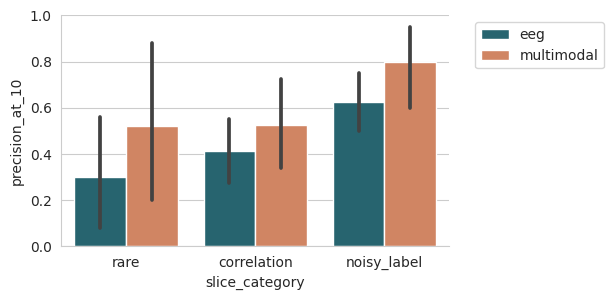

task: sdm_displot, run_id=4180


/home/ksaab/Documents/domino/domino/plot.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["alpha"] = grouped_df["alpha"].round(3)
[2021-10-02 17:48:45,255][WARNING][matplotlib.legend:1225] :: No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 200x2000 with 0 Axes>

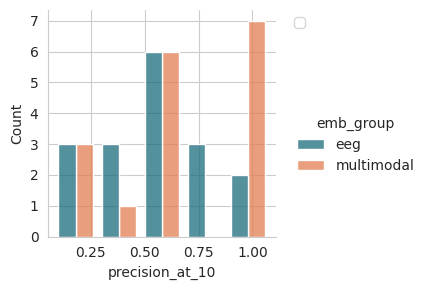

In [20]:
from domino.plot import sdm_barplot, sdm_displot, generate_group_df
sdm_barplot(
    score_sdm_ids=[4170],
    emb_groups=["eeg", "multimodal"],
    sdm_classes=["domino.sdm.gmm.MixtureModelSDM"],
    run_dir="."
)
# sdm_barplot(
#     score_sdm_ids=[3918],
#     emb_groups=["multimodal"],
#     sdm_classes=["domino.sdm.gmm.MixtureModelSDM", "domino.sdm.multiaccuracy.MultiaccuracySDM"],
# )
plt.savefig("figures/sdm_barplot.pdf")
plt.show()

sdm_displot(
    score_sdm_ids=[4170], #synthetics: 3918
    emb_groups=["eeg", "multimodal"],
    sdm_classes=["domino.sdm.gmm.MixtureModelSDM"],
    run_dir="."
)
plt.savefig("figures/sdm_displot.pdf")
plt.show()

task: sdm_barplot, run_id=4335
83


/home/ksaab/Documents/domino/domino/plot.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["alpha"] = grouped_df["alpha"].round(3)


<Figure size 640x480 with 0 Axes>

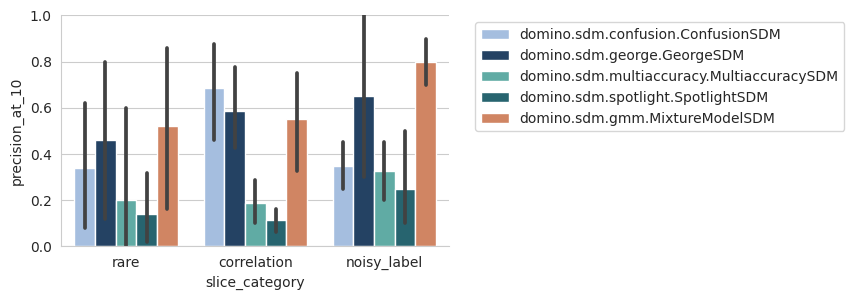

In [29]:
out = sdm_barplot(
    score_sdm_ids=[4336],
    emb_groups=["multimodal"],

    sdm_classes=[
        "domino.sdm.gmm.MixtureModelSDM",
        "domino.sdm.george.GeorgeSDM",
        "domino.sdm.multiaccuracy.MultiaccuracySDM",
        "domino.sdm.spotlight.SpotlightSDM",
        "domino.sdm.confusion.ConfusionSDM",
    ],
    hue="sdm_class"
)
plt.show()

In [21]:
df = generate_group_df(score_sdms_id=4170)
df.head()

/home/ksaab/Documents/domino/domino/plot.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["alpha"] = grouped_df["alpha"].round(3)


,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,...,precision,target_name,score_model_run_id,slice_name,index,emb_group,alpha,sdm_class,slice_category,success
852,4060,2,0,0.500539,0.1,0.04,0.01,0.142857,0.142857,0.142857,...,0.005181,sz,4008,age<1,852,eeg,0.010,domino.sdm.confusion.ConfusionSDM,rare,False
862,4066,2,0,0.500539,0.1,0.04,0.01,0.142857,0.142857,0.142857,...,0.005181,sz,4008,age<1,862,multimodal,0.010,domino.sdm.confusion.ConfusionSDM,rare,False
930,4071,0,0,0.422128,0.0,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,sz,4009,age<1,930,multimodal,0.027,domino.sdm.confusion.ConfusionSDM,rare,False
983,4088,3,0,0.635872,0.2,0.12,0.14,0.073171,0.170732,0.378049,...,0.141264,sz,4010,age<1,983,eeg,0.071,domino.sdm.confusion.ConfusionSDM,rare,False
993,4089,3,0,0.635872,0.2,0.12,0.14,0.073171,0.170732,0.378049,...,0.141264,sz,4010,age<1,993,multimodal,0.071,domino.sdm.confusion.ConfusionSDM,rare,False


In [28]:
sdm_classes=[
    "domino.sdm.gmm.MixtureModelSDM",
    "domino.sdm.george.GeorgeSDM",
    "domino.sdm.multiaccuracy.MultiaccuracySDM",
    "domino.sdm.spotlight.SpotlightSDM",
    "domino.sdm.confusion.ConfusionSDM",
]
for sdm in sdm_classes:
    print(len(df[df["sdm_class"]==sdm]))

34
34
27
0
33
